In [3]:
# This script goes along the blog post
# "Building powerful image classification models using very little data"
# from blog.keras.io.
# Modifications by Yannis Georgas 5-Jan-2019
# data for training and validation sets was scrapped and cleaned from instagram, flickr and other websites

from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# path to the model weights files.
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model_smax.h5'
# dimensions of our images.
img_width, img_height = 250, 250

train_data_dir = 'data/Train'
validation_data_dir = 'data/Validation'
nb_train_samples = 6720
nb_validation_samples = 2400
epochs = 10 # 50 is ideal but if it takes ages to train use 10 instead
batch_size = 16

# build the VGG16 network
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(250,250,3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(6, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs=base_model.input, outputs=top_model(base_model.output))

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

model.summary()

# fine-tune the model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2)

print('acc : ', history.history['acc'] )
print('loss: ', history.history['loss'] )

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18343922711123104301
]
Model loaded.
Found 6720 images belonging to 6 classes.
Found 2400 images belonging to 6 classes.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_____________________________________________________________

In [4]:
model.save_weights('Fine_tune_weights_fashion.h5')

In [5]:
model.save('fashion_model.h5')

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

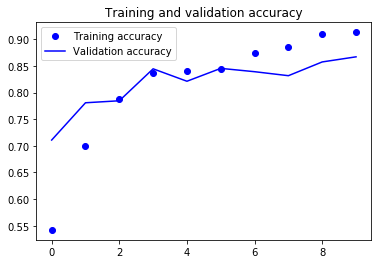

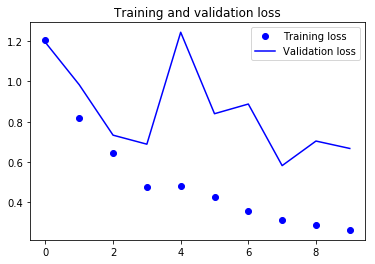

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()